In [343]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import datetime as dt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [344]:
conn = sqlite3.connect(r"C:\Users\Igor\PycharmProjects\pythonProject\py-restaurant-data-analysis\db.sqlite3")
cursor = conn.cursor()
cursor.execute("""SELECT name FROM sqlite_master
  WHERE type='table';""")
list_of_tables = cursor.fetchall()[1:]
for table in list_of_tables:
    df = pd.read_sql(f"SELECT * FROM {table[0]}", conn, index_col=None)
    df.to_csv(rf"C:\Users\Igor\PycharmProjects\pythonProject\py-restaurant-data-analysis\{table[0]}.csv", index=False)
restaurant_order = pd.read_csv(r"C:\Users\Igor\PycharmProjects\pythonProject\py-restaurant-data-analysis\restaurant_order.csv", index_col=None)
restaurant_order_item = pd.read_csv(r"C:\Users\Igor\PycharmProjects\pythonProject\py-restaurant-data-analysis\restaurant_orderitem.csv", index_col=None)
restaurant_products = pd.read_csv(r"C:\Users\Igor\PycharmProjects\pythonProject\py-restaurant-data-analysis\restaurant_product.csv", index_col=None)

In [345]:
merge_tabs = pd.merge(left=restaurant_products, right=restaurant_order_item, how="right", left_on="id", right_on="product_id")
merge_tabs1 = pd.merge(left=merge_tabs, right=restaurant_order, how="left", left_on="order_id", right_on="id")
merge_tabs1.drop("id_x", inplace=True, axis=1)
merge_tabs1

,price,name,id_y,quantity,order_id,product_id,id,datetime
0,0.80,Plain Papadum,1,2,1,6,1,2019-08-03 20:25:00
1,12.95,King Prawn Balti,2,1,1,240,1,2019-08-03 20:25:00
2,2.95,Garlic Naan,3,1,1,19,1,2019-08-03 20:25:00
3,3.95,Mushroom Rice,4,1,1,36,1,2019-08-03 20:25:00
4,8.95,Paneer Tikka Masala,5,1,1,111,1,2019-08-03 20:25:00
...,...,...,...,...,...,...,...,...
74813,17.95,House Red wine 75cl,74814,2,3255,247,3255,2016-05-18 18:53:00
74814,17.95,House Red wine 75cl,74815,2,12905,247,12905,2016-05-14 19:28:00
74815,17.95,House Red wine 75cl,74816,2,3272,247,3272,2016-05-10 13:18:00
74816,17.95,House white wine 75cl,74817,1,11404,248,11404,2016-04-07 19:04:00


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

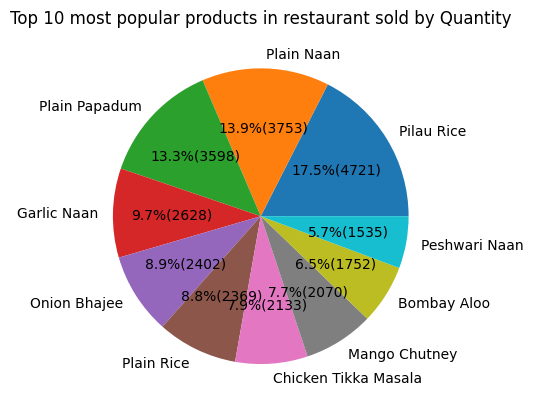

In [346]:
top_product = merge_tabs1.groupby(["name"])["quantity"].count().sort_values(ascending=False).head(10)
a_quantity = top_product.to_list()
plt.pie(top_product, labels=top_product.index, autopct=lambda p:f'{p:.1f}%({p*sum(a_quantity)/100:.0f})')
plt.title('Top 10 most popular products in restaurant sold by Quantity')
plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

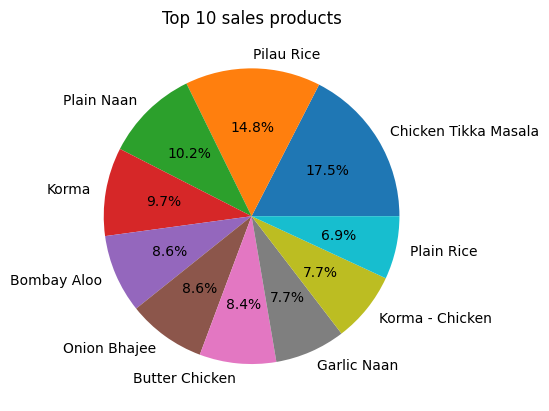

In [347]:
merge_tabs1["item_price"] = merge_tabs1['quantity'] * merge_tabs1['price']
top_sales = merge_tabs1.groupby(["name"])["item_price"].sum().sort_values(ascending=False).head(10)
plt.pie(top_sales, labels=top_sales.index, autopct= '%.1f%%')
plt.title('Top 10 sales products')
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

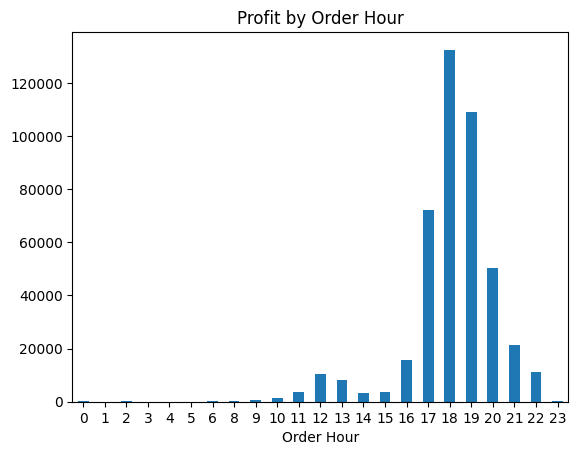

In [348]:
merge_tabs1["datetime"] = pd.to_datetime(merge_tabs1["datetime"])
merge_tabs1.groupby(merge_tabs1["datetime"].dt.hour)["item_price"].sum().plot(
    kind='bar', rot=0)
plt.xlabel("Order Hour")
plt.title("Profit by Order Hour")
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

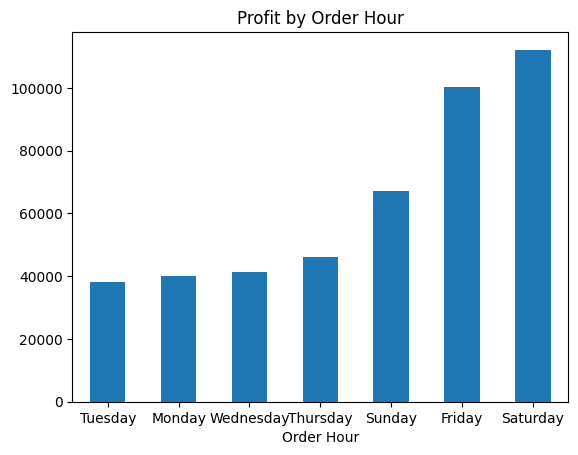

In [349]:
merge_tabs1["Week Day"] = merge_tabs1["datetime"].dt.day_name()
merge_tabs1.groupby(merge_tabs1["Week Day"])["item_price"].sum().sort_values().plot(
    kind='bar', rot=0)
plt.xlabel("Order Hour")
plt.title("Profit by Order Hour")
plt.show()